In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
%matplotlib inline

In [2]:
def posterior_predictive(X, y, sigma_y, kernel, X_star):
    K = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            K[i, j] = kernel(X[i], X[j])
    K += sigma_y**2 * np.eye(X.shape[0])
    
    K_star = np.zeros((X.shape[0], X_star.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X_star.shape[0]):
            K_star[i, j] = kernel(X[i], X_star[j])
    
    K_star_star = np.zeros((X_star.shape[0], X_star.shape[0]))
    for i in range(X_star.shape[0]):
        for j in range(X_star.shape[0]): #note: could be made more efficient using K's symmetry
            K_star_star[i, j] = kernel(X_star[i], X_star[j])
    
    posterior_mean = K_star.T @ np.linalg.inv(K) @ f
    posterior_cov = K_star_star - K_star.T @ np.linalg.inv(K) @ K_star
    
    return posterior_mean, posterior_cov

## A few kernels

In [3]:
def sq_exp_kernel(sigma=1, l=1):
    """
    l determines the length of the 'wiggles' in your function. 
    You won't be able to extrapolate more than l units away from your data.
    sigma determines the average distance of your function away from its mean.
    """
    return lambda x1, x2: sigma**2 * np.exp(-np.dot((x1 - x2), (x1 - x2)) / (2 * l**2))

In [4]:
def spectral_kernel(w, mu, v):
    """
    Note q is number of mixture components, p is dimension of input
    
    w - q x 1 vector
    weight of each gaussian mixture component
    
    mu - q x p matrix
    mean of each gaussian mixture component
    
    v - q x p matrix
    variance of each gaussian mixture component
    
    source: http://www.cs.cmu.edu/~andrewgw/typo.pdf
    """
    def kern_func(x1, x2):
        Tau = x1 - x2 
        exp = np.exp(-2 * np.pi**2 * v * (Tau**2).T) #  q x p
        prod = np.prod(exp, axis=1) #  q x 1
        cos = np.cos(2 * np.pi * mu @ Tau) # q x 1
        return np.sum((w * cos).T * prod)
    
    return kern_func

## Test Spectral Kernel

In [5]:
q_test = 10
p_test = 2
w_test = 2 * np.ones((q_test, 1))
mu_test = np.ones((q_test, p_test))
v_test = np.ones((q_test, p_test))
k_test = spectral_kernel(w_test, mu_test, v_test)

assert k_test(np.ones((p_test, 1)), np.ones((p_test, 1))) == 2 * q_test
assert np.isclose(k_test(np.zeros((p_test, 1)), .125 * np.ones((p_test, 1))), 0)

## Fit Spectral Kernel

### Partials

$ll(x, k) \propto -\log |k| -  x^T k^{-1} x$

$\frac{\partial ll(x, k)}{\partial k} \propto k^{-1}x x^T k^{-1} - k^{-1}$

$\frac{\partial k}{\partial w_q} = \cos(2\pi \tau^T\mu_q)\prod_p \exp(-2\pi^2\tau_p^2 v_q^{(p)})$

$\frac{\partial k}{\partial \mu_q} = -2\pi\tau w_q \sin(2\pi \tau^T\mu_q)\prod_p \exp(-2\pi^2\tau_p^2 v_q^{(p)})$

$\frac{\partial k}{\partial v_q^{(j)}} = -2\pi^2\tau_j^2 w_q [\cos(2\pi \tau^T\mu_q)]^{(j)}\prod_p \exp(-2\pi^2\tau_p^2 v_q^{(p)})$

### Sources

https://arxiv.org/pdf/1302.4245.pdf

https://github.com/cdipaolo/GPy/blob/daf2fc868e41c5037dac10fbb16b7da2be614106/GPy/kern/src/spectral_mixture.py

http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf

https://stats.stackexchange.com/questions/27436/how-to-take-derivative-of-multivariate-normal-density


In [6]:
def gradf(x, *args):
    """
    x = w, mu, v
    args = X, sigma_y
    
    
    Note q is number of mixture components, p is dimension of input
    
    w - q x 1 vector
    weight of each gaussian mixture component
    
    mu - q x p matrix
    mean of each gaussian mixture component
    
    v - q x p matrix
    variance of each gaussian mixture component
    
    X - n x p matrix
    data
    
    sigma_y - n x 1 matrix
    variance of each data point, i.e. confidence in each sample
    """
    w, mu, v = x
    X, sigma_y = args


    # highly inefficient, could be vectorized, used for testing
    n = X.shape[0]
    q = w.shape[0]
    dk_dw = np.zeros_like(w)
    dk_dmu = np.zeros_like(mu)
    dk_dv = np.zeros_like(v)
    for i in range(n):
        for j in range(n):
            Tau = X[i] - X[j] #  p x 1
            
            cos = np.cos(2 * np.pi * mu @ Tau)[:, np.newaxis] # q x 1
            exp = np.exp(-2 * np.pi**2 * v * (Tau**2).T) #  q x p
            prod = np.prod(exp, axis=1)[:, np.newaxis] #  q x 1
            sin =  -2 * np.pi * w * np.sin(2 * np.pi * mu @ Tau)[:, np.newaxis] * Tau.T # q x p
            dk_dw += cos * prod
            dk_dmu += sin * prod
            dk_dv += -2 * np.pi**2 * Tau**2 * w * cos * prod
            
            
    
    return dk_dw, dk_dmu, dk_dv


def optimize_spectral_kernel(w0, mu0, v0, X, sigma_y):
    def f(x, *args):
        w, mu, v = x
        X, sigma_y = args  
        
        kernel = spectral_kernel(w, mu, v)
        K = np.zeros((X.shape[0], X.shape[0]))
        for i in range(X.shape[0]):
            for j in range(X.shape[0]):
                K[i, j] = kernel(X[i], X[j])
        K += sigma_y**2 * np.eye(X.shape[0])
        
        return np.log(np.linalg.det(K)) + X.T @ np.linalg.inv(K) @ X
    
    return optimize.fmin_cg(f, (w0, mu0, v0), fprime=gradf, args=(X, sigma_y))


## Test Spectral Kernel Gradient

In [7]:
n_test = 2
q_test = 3
p_test = 5
w_test = np.ones((q_test, 1)) / p_test
mu_test = np.ones((q_test, p_test))
v_test = np.ones((q_test, p_test))
sigma_y_test = np.zeros(n_test)

X_test = np.ones((n_test, p_test))
dk_dw, dk_dmu, dk_dv = gradf((w_test, mu_test, v_test), X_test, sigma_y_test)
assert (dk_dw == n_test**2).all()
assert (dk_dmu == 0).all()
assert (dk_dv == 0).all()

X_test = np.zeros((n_test, p_test))
X_test[1] += 1 / 2
dk_dw, dk_dmu, dk_dv = gradf((w_test, mu_test, v_test), X_test, sigma_y_test)
assert np.isclose(dk_dmu, 0).all()

X_test = np.zeros((n_test, p_test))
X_test[1] += 1e-5
mu_test = np.zeros((q_test, p_test))
dk_dw, dk_dmu, dk_dv = gradf((w_test, mu_test, v_test), X_test, sigma_y_test)
assert np.isclose(dk_dv, n_test * -2 * np.pi**2 * 1e-10 * w_test[0]).all()

In [8]:
def plot_GP(X, f, mu_star, sigma_star):
    plt.scatter(X, f, c='red', label='X')
    sigma = sigma_star.diagonal()
    plt.fill_between(X_star, (mu_star - sigma), (mu_star + sigma), alpha=.5, label='sigma')
    plt.plot(X_star, mu_star, label='mu_star')
    plt.legend(loc=3, bbox_to_anchor=(0., 1.02, 1., .102), mode='expand')
    plt.show()

## Test Data

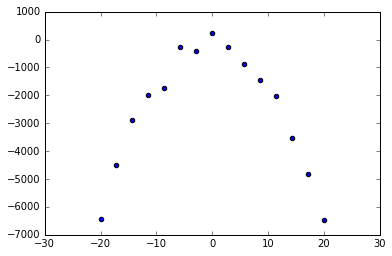

In [9]:
order = 3
X = np.linspace(-20, 20, 15)
genweights = 10 * np.random.randn(order)
def poly(i):
    return (genweights.T @ np.array([i**p for p in range(order)]) 
            + np.random.normal(0, 10*order**order))
polyfunc = np.vectorize(poly)
f = polyfunc(X)
plt.scatter(X, f)

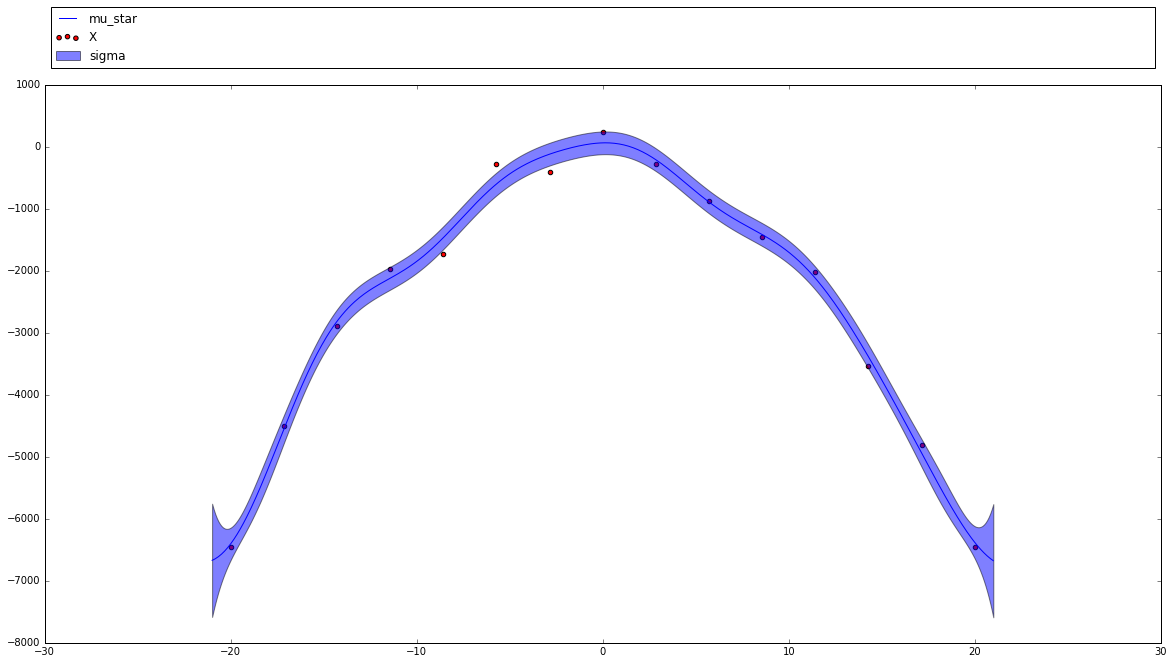

In [10]:
sigma_y = np.ones(15) * np.sqrt(10*order**order)
X_star = np.linspace(-21, 21, 500)
mu_star, sigma_star = posterior_predictive(X, f, sigma_y, sq_exp_kernel(sigma=10*order**order, l=5), X_star)
plt.figure(figsize=(20,10))
plot_GP(X, f, mu_star, sigma_star)

/home/nate/.local/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: covariance is not positive-semidefinite.


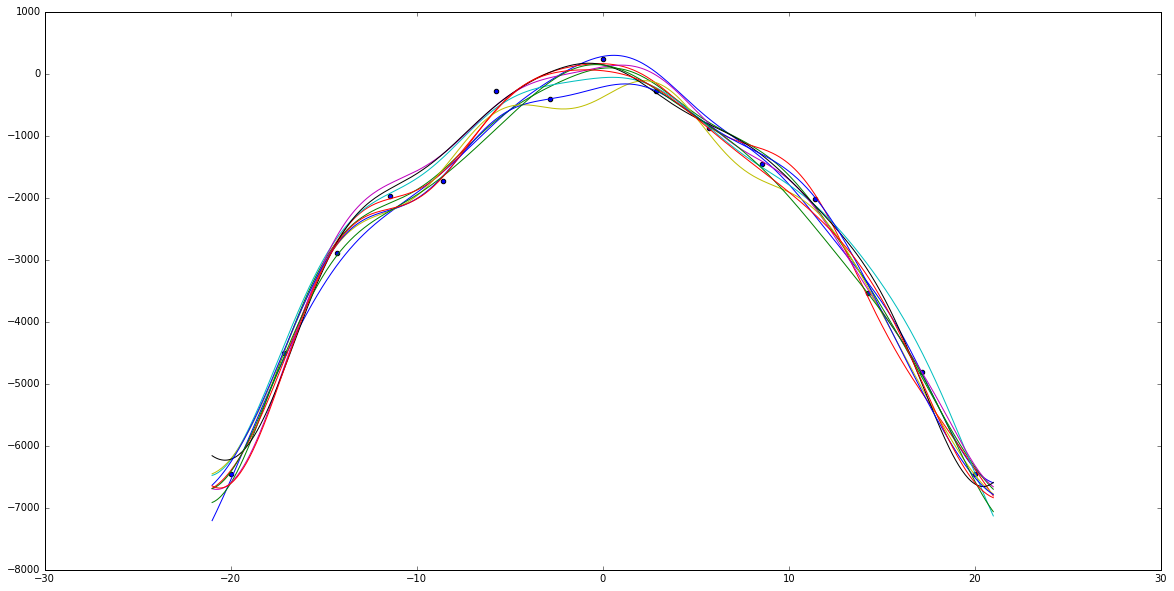

In [11]:
plt.figure(figsize=(20, 10))

# sample from posterior predictive
for i in range(10):
    plt.plot(X_star, np.random.multivariate_normal(mean=mu_star, cov=100*sigma_star))
    
plt.scatter(X, f)
plt.show()